In [1]:
from jax.config import config
config.update("jax_enable_x64", True)

import jax.numpy as jnp
from jax import random, vmap, jit, grad
import jax.scipy as scipy




import matplotlib.pyplot as plt

from utils_rough_pde import *
from utils_elliptic_coef import *

import time

from tqdm import tqdm


/tmp/ipykernel_3360114/2806640137.py:1: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config


In [2]:
# Define the domain of the problem
lower = 0.0
upper = 1.0
L = upper - lower
x = jnp.linspace(0, 1, 1000)
boundary = jnp.array([[lower, upper]]).T
boundary_conditions = jnp.zeros(shape = (2, )) # Dirichlet boundary conditions
domain = jnp.array([lower, upper])

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [3]:
plt.style.use('plot_style-Examples.txt')
#plt.style.use('default')

# 16:9 aspect ratio
width = 4
height = width * 3 / 4

# Generating white noise


We will use a basis 

$$
u = \sum_{i}^N c_i\varphi_i
$$
with the the basis being tent functions. 

We will use the property
$$
[\xi, \varphi] \sim \mathcal{N}(0, A)
$$
where 

$$
A_{ij} = \langle \varphi_i, \varphi_j \rangle
$$


In [4]:
n_intervals = 2**13
n_meas = n_intervals -1 # We do not include the boundary points
print(n_intervals)
epsilon = (upper- lower)/n_intervals

8192


In [5]:
centers = jnp.linspace(lower, upper, n_intervals + 1)
epsilon = (upper - lower)/n_intervals
epsilon_values  = jnp.ones(n_intervals)*epsilon
intervals = jnp.array([centers[:-1], centers[1:]]).T

In [6]:
def compute_l2_ip(epsilon, center_1, center_2):
    condition1 = center_1 == center_2
    condition2 = jnp.allclose(jnp.abs(center_1 - center_2), epsilon)
    return jnp.where(condition1, 2 / (epsilon*3),
                     jnp.where(condition2, 1 / (epsilon*6), 0))

In [7]:
def build_L2_matrix(epsilon, centers, include_boundary):
    if include_boundary:
        L2_matrix = vmap_compute_l2_ip(epsilon, centers, centers)
        L_2_matrix = L_2_matrix.at[0, 0].set( L_2_matrix[0, 0]/2)
        L_2_matrix = L_2_matrix.at[-1, -1].set( L_2_matrix[-1, -1]/2)
    else:
        L2_matrix = vmap_compute_l2_ip(epsilon, centers[1:-1], centers[1:-1])
    
    return L2_matrix


In [8]:
L2_matrix = build_L2_matrix(epsilon, centers, include_boundary = False)
L_L2 = scipy.linalg.cholesky(L2_matrix + 1e-10*jnp.eye(n_intervals-1))

In [21]:
key = random.PRNGKey(0)
f_values = L2_matrix@random.normal(key, shape = (n_meas, ))

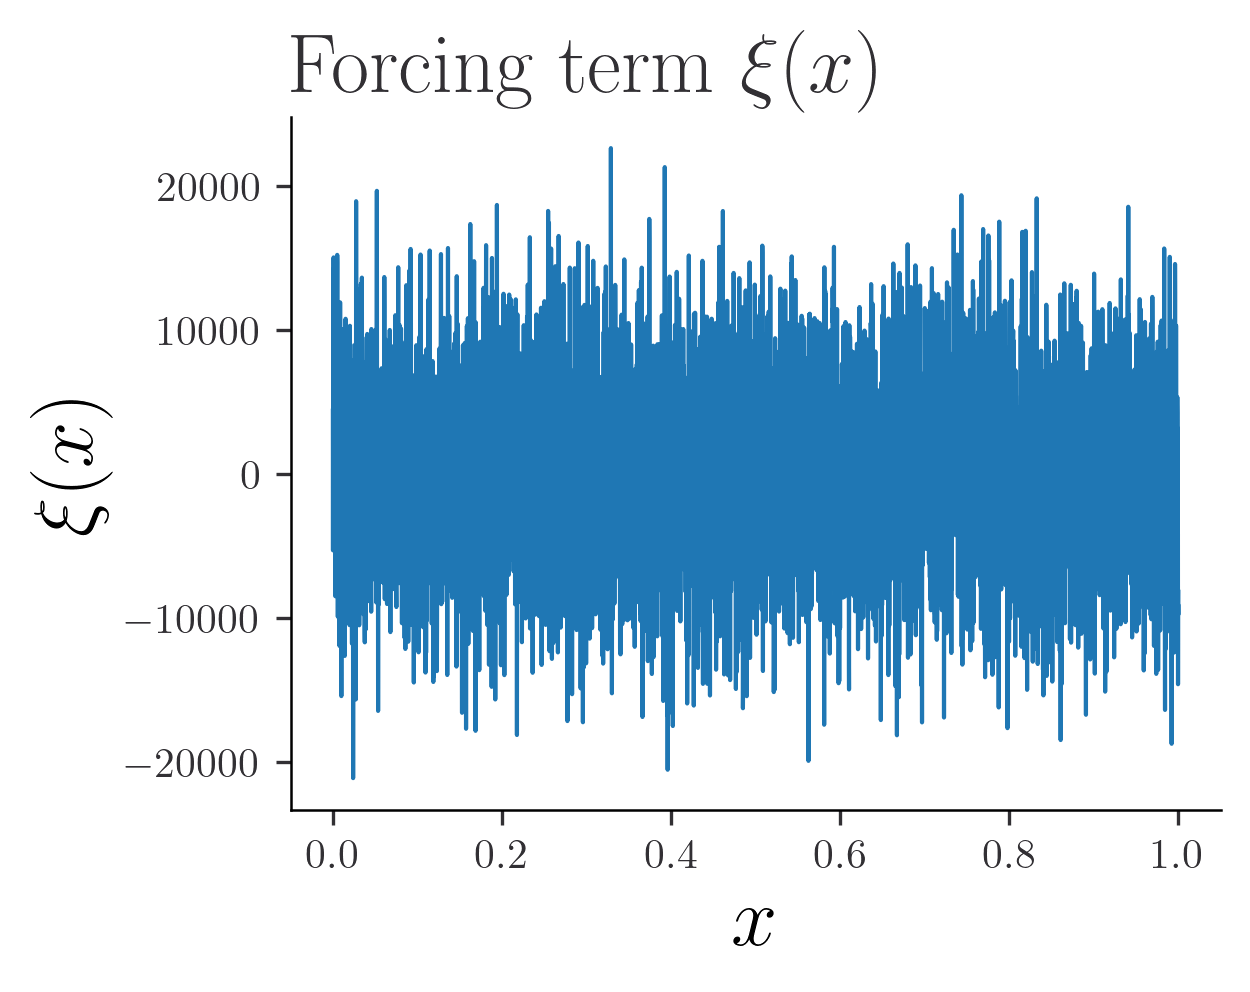

In [22]:
fig = plt.figure(figsize=(width, height))


plt.plot(centers[1:-1], f_values)
plt.xlabel(r'$x$')
plt.ylabel(r'$\xi(x)$')
plt.title(r'Forcing term $\xi(x)$')
plt.show()

In [18]:
f_coef = scipy.linalg.cho_solve((L_L2, False), f_values)
f_coef

Array([ 1.16720218, -1.4386431 ,  0.71058365, ..., -0.68888436,
       -1.32574514, -1.16516503], dtype=float64)

In [19]:
from utils_rough_pde import vmap_tent_evaluate

In [20]:
vmap_tent_evaluate(centers[1:-1], epsilon, centers[1:-1])@f_coef, f_values

(Array([  9561.72027008, -11785.36427744,   5821.10123499, ...,
         -5643.34070523, -10860.5041965 ,  -9545.03196562], dtype=float64),
 Array([ 4410.25280048, -5293.10593412,  3249.15911575, ...,
        -9050.5545709 , -9771.73157614, -8173.4386765 ], dtype=float64))

In [149]:
random.normal(key, shape = (n_meas, ))/epsilon, f_values

(Array([  9561.72027008, -11785.36427744,   5821.10123499, ...,
         -5643.34070523, -10860.5041965 ,  -9545.03196562], dtype=float64),
 Array([ 4410.25280048, -5293.10593412,  3249.15911575, ...,
        -9050.5545709 , -9771.73157614, -8173.4386765 ], dtype=float64))

In [143]:
from utils_DST import compute_sine_coefficients

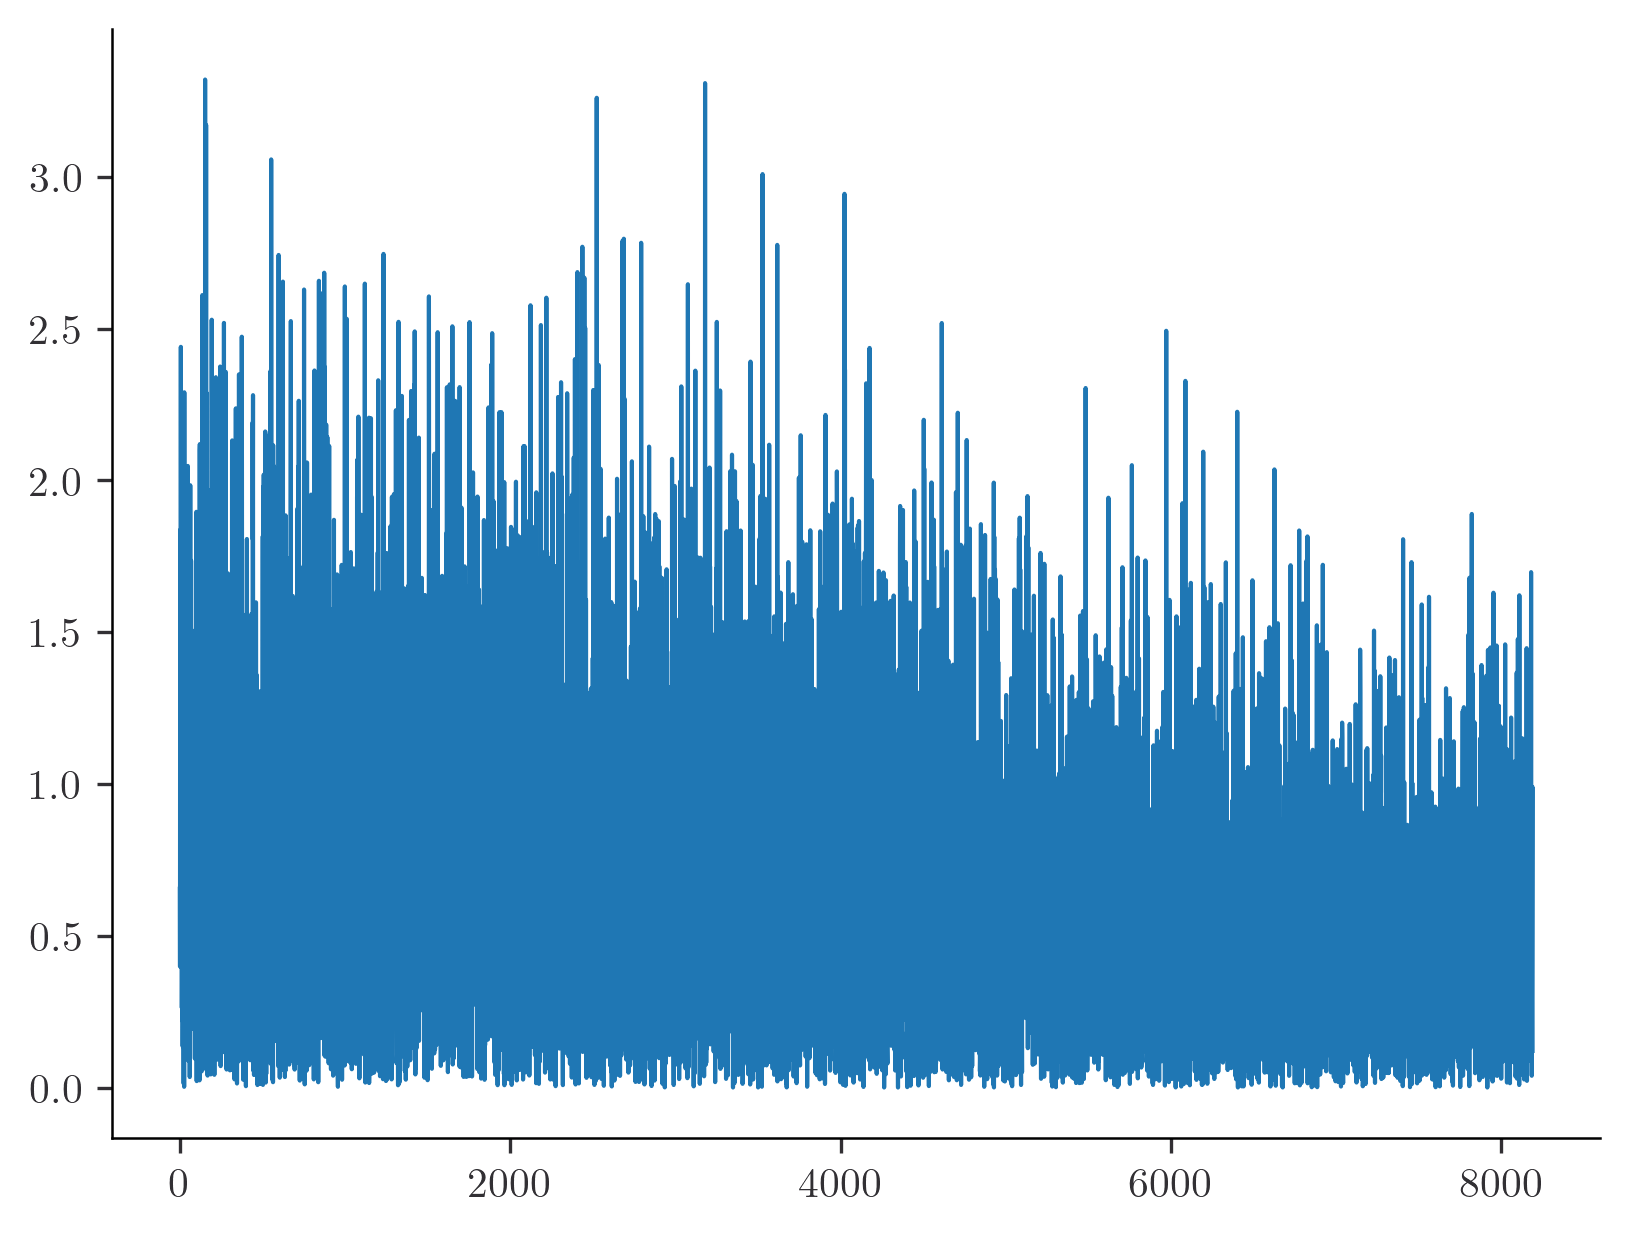

In [144]:
plt.plot(jnp.abs(compute_sine_coefficients(f_values)))

In [88]:
f_coef.shape

(4095,)

In [89]:
random.normal(key, shape = (n_meas, ))

Array([ 0.85601222, -0.03712835, -0.78414419, ...,  0.62924996,
        1.29528199,  0.33303541], dtype=float64)

In [90]:
f_coef/epsilon, f_values

(Array([ 71.93224085, -22.24969693, -57.684678  , ...,  32.61836846,
         96.39193629,   1.11706349], dtype=float64),
 Array([ 44.24654441, -12.45853748, -28.79555487, ...,  49.27994147,
         69.88386286,  16.81003171], dtype=float64))

# Generating white noise

To test the accuracy of our method we will sample 

$$
\xi \sim \sum_{i=j}^N \xi_j \sqrt{2}\sin(j \pi x)
$$

and project onto a tent function basis:

$$
[\xi, \varphi] = \sum_{i=1}^N \xi_i \langle  \varphi, \sqrt{2}\sin(j \pi x) \rangle
$$

The inner product will be computed using the DST. 

In [43]:
from importlib import reload
import utils_DST

utils_DST = reload(utils_DST)
from utils_DST import discrete_sine_transform, vmap_compute_sine_coef

In [32]:

key = random.PRNGKey(111)
nu = 0.01


n_coef = 2**14
upper = 1.0
lower = 0.0
boundary = jnp.array([lower, upper])
boundary_conditions = jnp.array([0.0, 0.0])

domain_finest = jnp.linspace(lower,upper,n_coef+1, endpoint=False)[1:] # Do not include 0 or 1!
print(n_coef)

frequencies = jnp.arange(0, n_coef) + 1
coef_f = jnp.hstack([random.normal(key, shape= (n_coef,))]) 
coef_u = coef_f/(nu*frequencies**2*jnp.pi**2 + 1)

f_values = discrete_sine_transform(coef_f)
u_values = discrete_sine_transform(coef_u)

16384


In [31]:
centers.shape, domain_finest.shape

((8193,), (16384,))

In [68]:
n_intervals = 2**12
n_meas = n_intervals -1 # We do not include the boundary points
print(n_intervals)
epsilon = (upper- lower)/n_intervals

4096


In [69]:
centers = jnp.linspace(lower, upper, n_intervals + 1)
epsilon = (upper - lower)/n_intervals
epsilon_values  = jnp.ones(n_intervals)*epsilon
intervals = jnp.array([centers[:-1], centers[1:]]).T

In [71]:
tent_values = vmap_tent_evaluate(domain_finest, epsilon, centers[1:-1]).T

In [72]:
tent_proj_coef = vmap_compute_sine_coef(tent_values)

In [73]:
tent_proj_coef.shape, f_values.shape

((4095, 16384), (16384,))

In [74]:
white_noise = tent_proj_coef@f_values

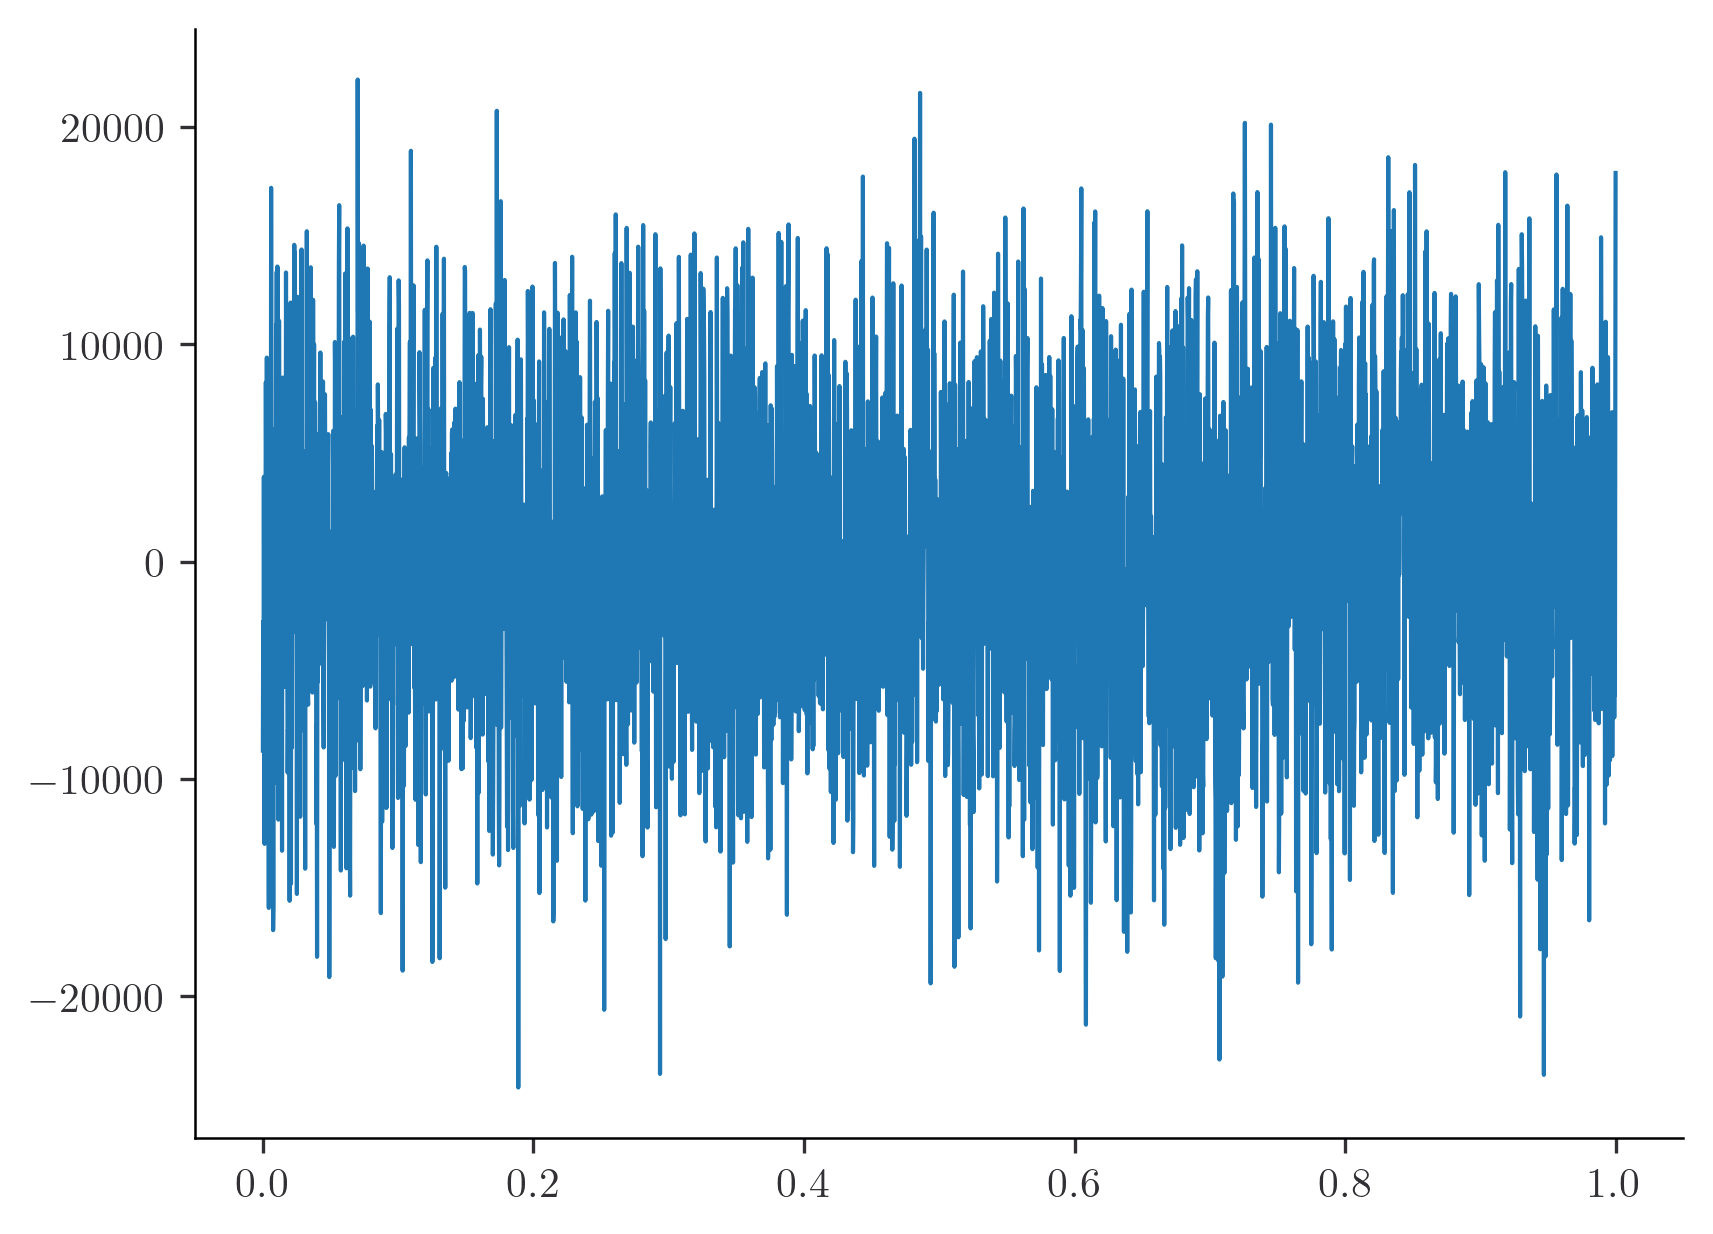

In [75]:
plt.plot(centers[1:-1], white_noise)

In [61]:
discrete_sine_transform(tent_proj_coef[0]) - tent_values[0]

Array([-1.77635684e-15,  3.19744231e-14, -2.13162821e-14, ...,
        5.56990213e-15,  9.23077669e-16,  2.29407944e-15], dtype=float64)

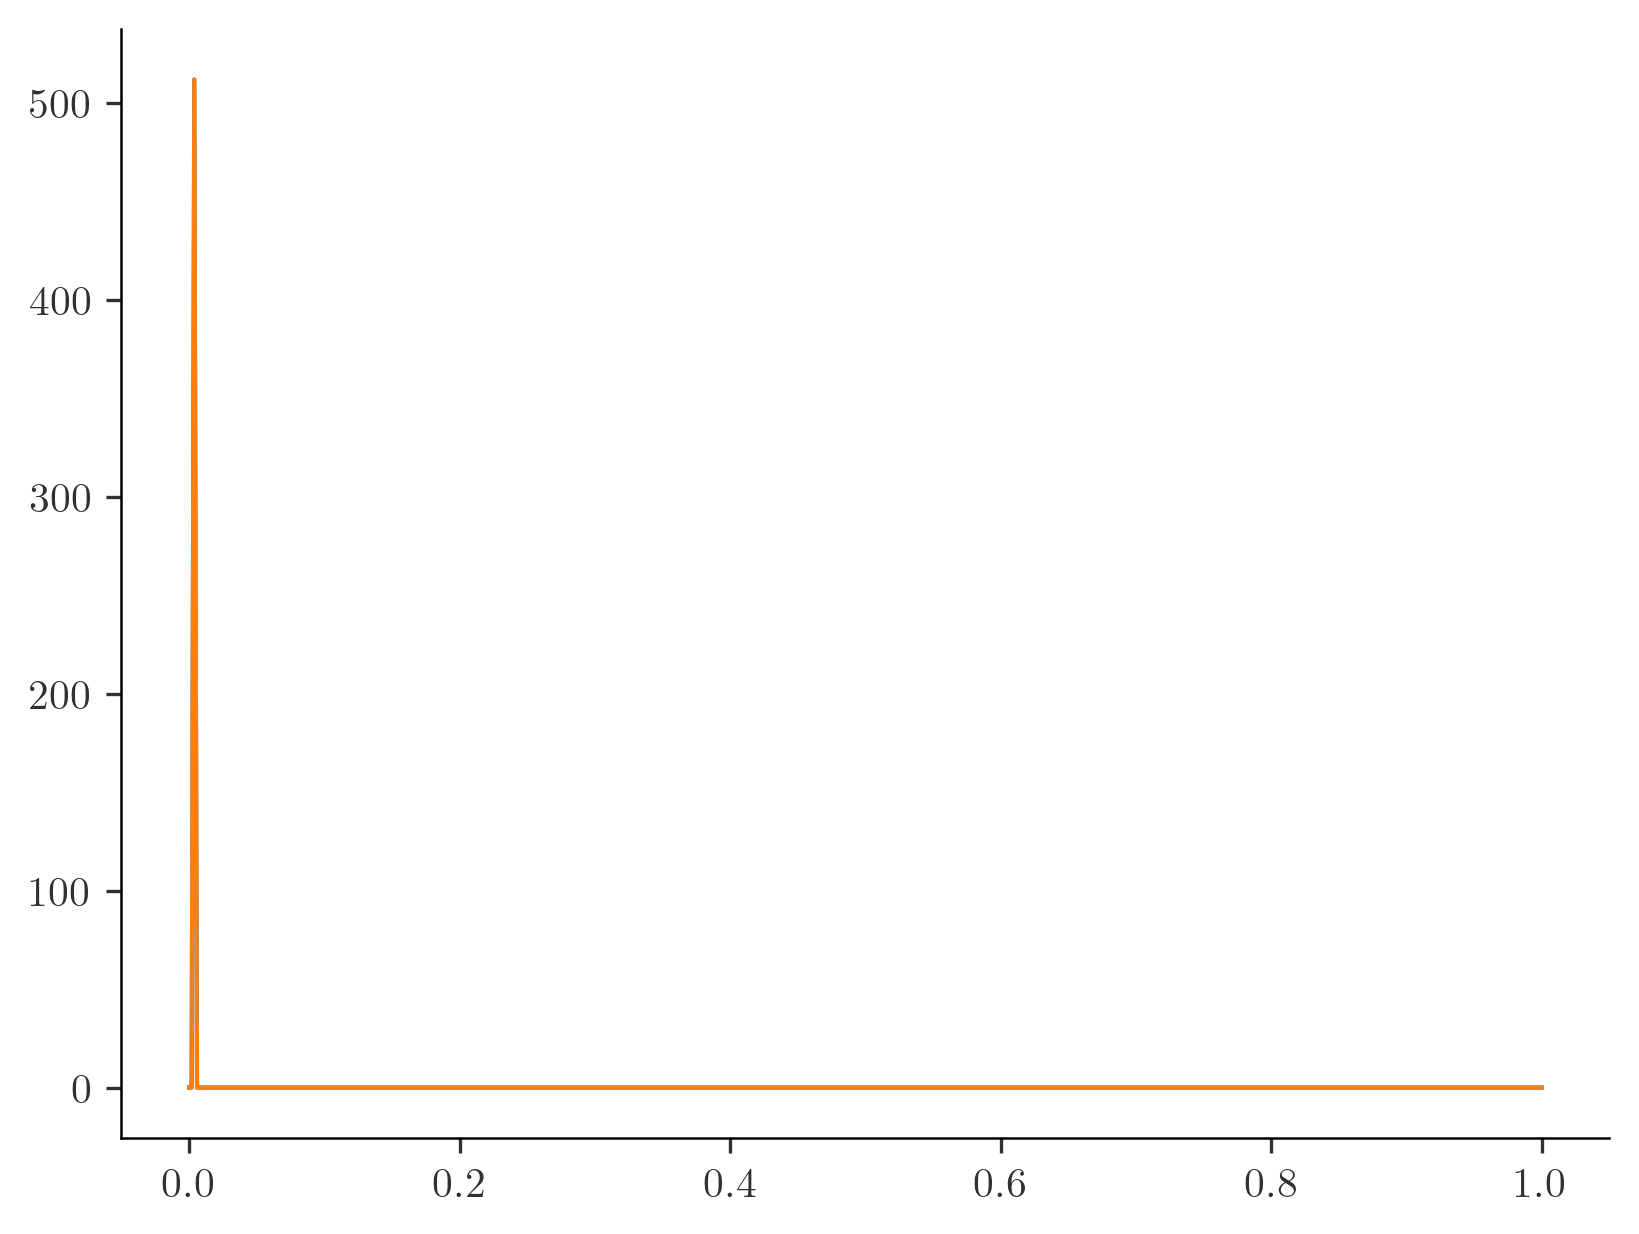

In [63]:
plt.plot(domain_finest, discrete_sine_transform(tent_proj_coef[1]))
plt.plot(domain_finest, tent_values[1])

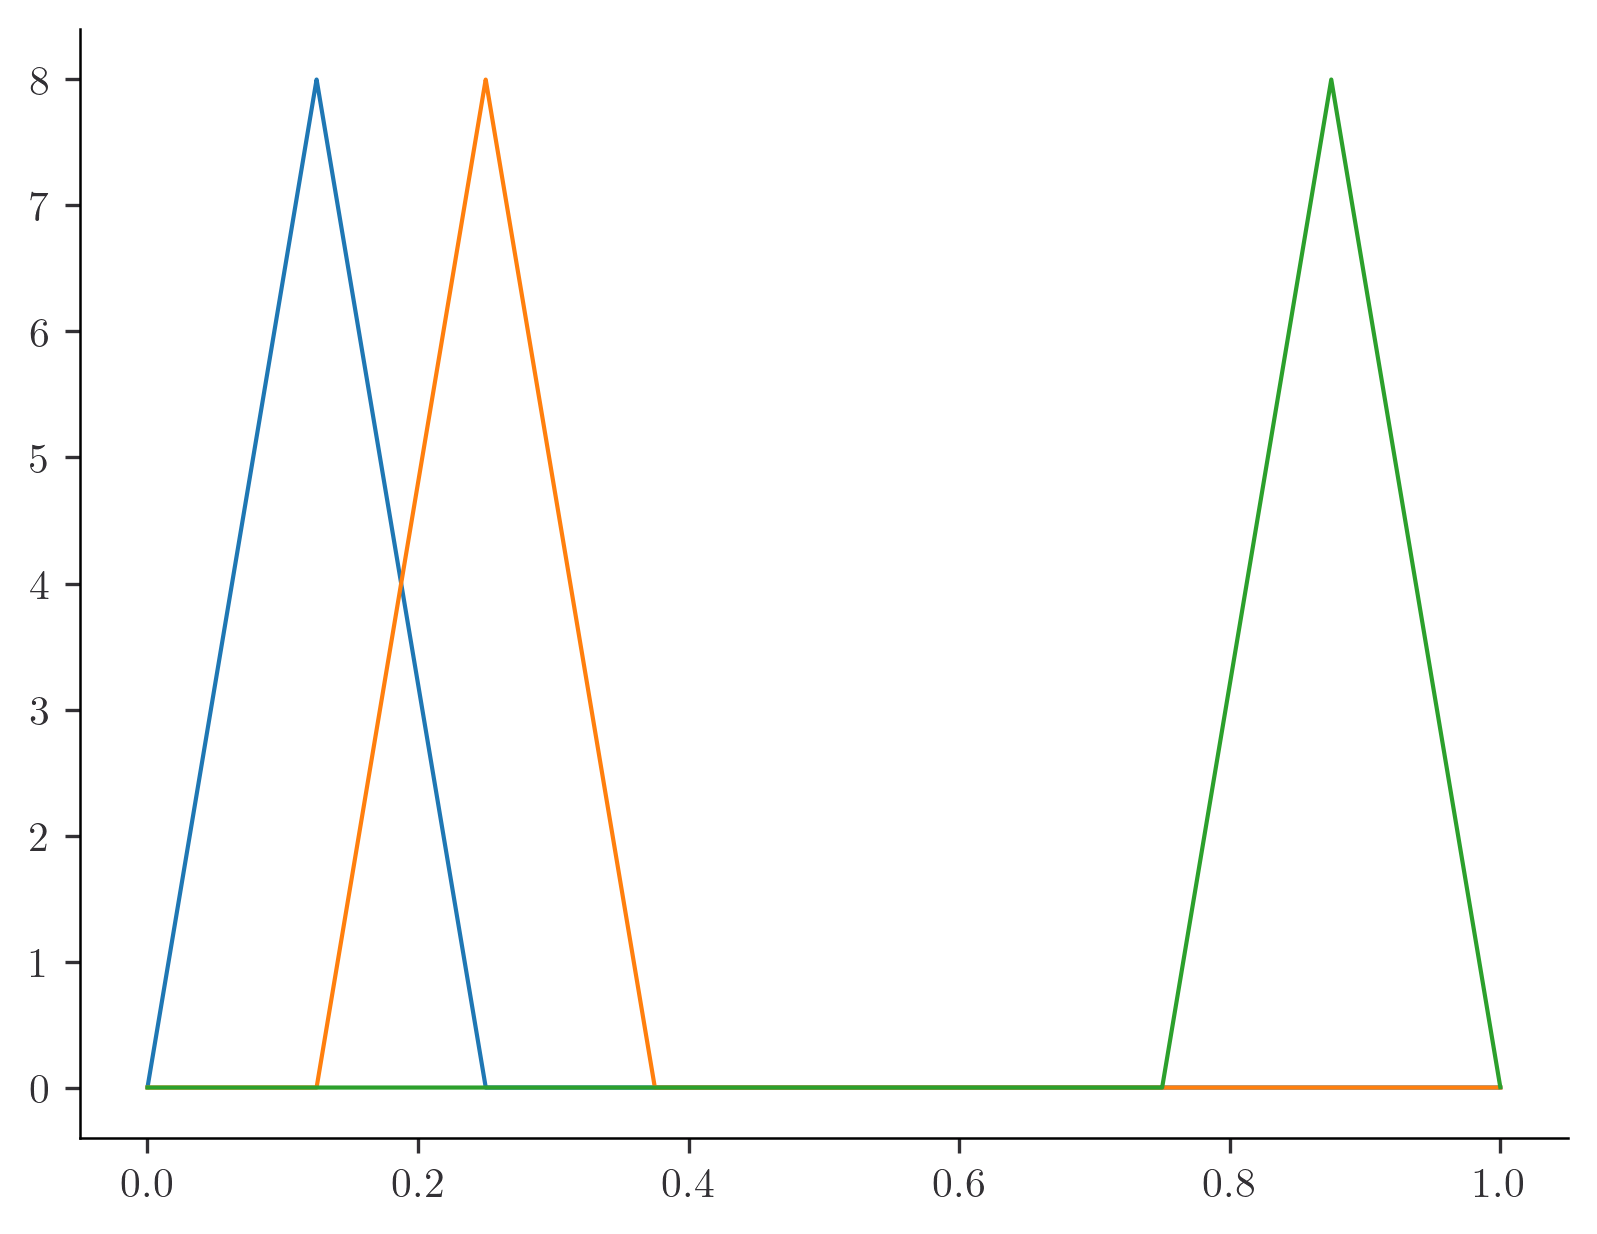

In [42]:
plt.plot(domain_finest, tent_values[:, 0])
plt.plot(domain_finest, tent_values[:, 1])
plt.plot(domain_finest, tent_values[:, -1])

# Solve the PDE

In [ ]:
# Build the kernel matrix
theta_11 = vmap_kernel(boundary, boundary, length_scale)
theta_12 = vmap_L_b_y(boundary, domain_measurements, length_scale, nu, b(domain_measurements))
theta_22 = vmap_L_b_xy(domain_measurements, domain_measurements, length_scale,nu, b(domain_measurements), b(domain_measurements))